<a href="https://colab.research.google.com/github/BrainConnection/Qiskit/blob/main/Open%20Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
The problem of encoding information in a quantum state is crucial for realizing many applications of quantum computing. Therefore, in order to harness the full potential of quantum computing, the development schemes that can accurately store information efficiently in quantum states is paramount. In the current NISQ era of quantum computing, such schemes must also satisfy the condition of robustness to quantum errors. In this project, we will implements a form of amplitude encoding proposed in [1], which uses a divide-and-conquer strategy using binary trees to generate angles with which states are generated, and is also capable of storing complex vectors as well as real vectors. We compare the error robustness to different quantum errors such as bit-flip, phase-flip, depolarzing, phase-damping, and amplitude damping of this scheme to traditional amplitude encoding and demonstrate its higher robustness.

We demonstrate that the divide and conquer scheme algorithm is as robust to all of the aforementioned errors as traditional amplitude embeddding, with robustness increasing with the input state's uniformity. Also we find that the divide and conquer algorithm speeds up the preparation of states with the cost of extra qubits.

# Environment Setup

In [2]:
import pennylane as qml
import pennylane.numpy as np
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import qiskit_aer.noise as noise
import qiskit

# Utility Functions

In [3]:
def generate_tree(N):
    tree = []
    count = 0
    step = 0
    while count < N:
        tree.append(list(range(count, count+2**(step),1)))
        count += 2**(step)
        step +=1
    return tree 


def obtain_parent(tree, target_index):
    num, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)
    parent = tree[layer-1][int(np.ceil((position_index+1) / 2)) -1]
    return parent
    

def rearrange_qubits(tree):
    qubits = [0]*(tree[len(tree)-1][-1]+1)
    for i in range(len(tree)):
        temp = tree[len(tree)-i-1][::-1]
        for j in range(len(temp)):
            qubits[2**(i)+j*2**(i+1)-1] = temp[j]    
    return qubits



def nearest_tree_num(N):
    num = 1
    step = 1
    while num < N:
        num += 2**(step)
        step +=1

    return num, step    


def obtain_child_index(tree,target_index):
    child_indices =[]
    _, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)    
    child_indices.append(tree[layer+1][2*(position_index+1)-2])
    child_indices.append(tree[layer+1][2*(position_index+1)-1])
    return child_indices

def obtain_parent(tree, target_index):
    _, step = nearest_tree_num(target_index+1)
    layer = step-1
    position_index = tree[layer].index(target_index)
    parent = tree[layer-1][int(np.ceil((position_index+1) / 2)) -1]
    return parent      


# Test Vector

In [60]:

x = np.array([np.sqrt(0.1),np.sqrt(0.15),np.sqrt(0.125),np.sqrt(0.125),np.sqrt(0.125),np.sqrt(0.125),np.sqrt(0.125),np.sqrt(0.125)])
#x = np.array([1,2,3,4,5,6,7,8])
N = int(np.shape(x)[0])

num_qubits = int(np.ceil(np.log2(N)))
x_norm =x/np.linalg.norm(x)
x_density = np.outer(x_norm,x_norm)


## Real Data Amplitude Embedding 

In [62]:
def amplitude_embedding(x,dev,verbose=False):
  """
  Conduct Amplitude Embdding

  Args
    - x (numpy.tensor): a length-N vector

  Returns
    - state (qml.measurements.StateMP): Embedded state
  """

  x = x/np.linalg.norm(x)
  N = np.shape(x)[0]
  num_qubits = (int)(np.log2(N))


  def theta_generate(x):
    y = []

    for i in range(num_qubits):
      lst = []

      for j in range(2**(i+1)):
        sum = 0

        num = (int)(N/2**(i+1))
        for k in range(j*num, (j+1)*num, 1):
          sum = sum + x[k]**2

        lst.append(np.sqrt(sum))

      y.append(lst)

    theta = []

    for i in range(num_qubits):
      lst = []

      if i==0:
        lst.append(2*np.arccos(y[i][0]))

      else:
        for j in range(2**i):
          lst.append(2*np.arccos(y[i][2*j]/y[i-1][j]))

      theta.append(lst)

    return theta


  def control_generate(num_qubits):
    control = []

    for i in range(1, num_qubits):
      lst_1 = []

      for j in range(2**i):
        lst_2 = []

        num = j
        for k in range(i):
          lst_2.append(num % 2)
          num = num // 2

        lst_2.reverse()
        lst_1.append(lst_2)

      control.append(lst_1)

    return control


  @qml.qnode(dev)
  def amplitude_embedding():

    theta = theta_generate(x)
    control_bit = control_generate(num_qubits)

    qml.RY(theta[0][0],0)

    for i in range(1, num_qubits, 1):
      for j in range(2**i):
        U = np.array([[np.cos(theta[i][j]/2), -np.sin(theta[i][j]/2)], [np.sin(theta[i][j]/2), np.cos(theta[i][j]/2)]])
        qml.ControlledQubitUnitary(U, control_wires=range(i), wires=[i], control_values=control_bit[i-1][j])


    return qml.probs(range(num_qubits))

  if verbose:
    print(qml.draw(amplitude_embedding)())
    print()

  return np.sqrt(amplitude_embedding())

In [80]:
def simulate_amplitude(x, p_list):
    F_list = []
    N = np.shape(x)[0]
    num_qubits = (int)(np.log2(N))
    for p in p_list:
        bit_flip = pauli_error([('X', p), ('I', 1 - p)])
        phase_flip = pauli_error([('Z', p), ('I', 1 - p)])
        depolarizing = depolarizing_error(p, 1)
        phase_damping = noise.phase_damping_error(p)
        amplitude_damping = noise.amplitude_damping_error(p)

        my_noise_model = NoiseModel()
        #my_noise_model.add_all_qubit_quantum_error(bit_flip, ["ry","h"])
        #my_noise_model.add_all_qubit_quantum_error(phase_flip, ["ry","h"])
        #my_noise_model.add_all_qubit_quantum_error(depolarizing, ['ry'])
        #my_noise_model.add_all_qubit_quantum_error(phase_damping, ['ry'])
        my_noise_model.add_all_qubit_quantum_error(amplitude_damping, ['ry'])

        dev = qml.device('qiskit.aer', wires=range(num_qubits), noise_model = my_noise_model)
 
        x_noisy = amplitude_embedding(x,dev)
        x_noisy_density = np.outer(x_noisy,x_noisy)
        F = qml.math.fidelity(x_density,x_noisy_density)
        F_list.append(F)
    return F_list

In [81]:
p_list = np.linspace(0.01,0.5,500)
p_list = p_list.tolist()
fidelities_amplitude = simulate_amplitude(x,p_list)


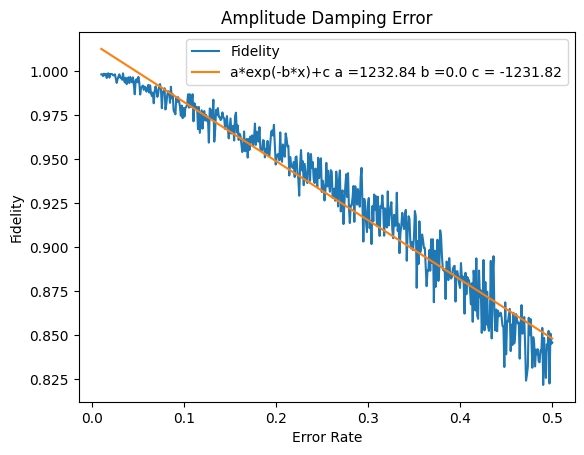

In [82]:
import matplotlib.pyplot as plt
import scipy

plt.plot(p_list,fidelities_amplitude,label="Fidelity")
plt.title("Amplitude Damping Error")
plt.ylabel("Fidelity")
plt.xlabel("Error Rate")

def exp(x,a,b,c):
    return a*np.exp(-b*x)+c

popt, pcov  = scipy.optimize.curve_fit(exp,p_list,fidelities_amplitude,maxfev=50000)

plt.plot(p_list,exp(np.array(p_list),*popt),label="a*exp(-b*x)+c" + " " + "a =" + f"{round(popt[0],2)}" + " b =" +  f"{round(popt[1],2)}" + " " +  "c = " +  f"{round(popt[2],2)}")
plt.legend()


# Bit-Flip Error
The following plots are for two different states, on the right the state $x = (1,2,3,4,5,6,7,8)$ was used and for the left the state $x = (\sqrt(0.1),\sqrt(0.15),\sqrt(0.125)\sqrt(0.125)\sqrt(0.125)\sqrt(0.125),\sqrt(0.125),\sqrt(0.125))$


![Bit Flip Error_1.png](<attachment:Bit Flip Error_1.png>)
![Bit Flip Error.png](<attachment:Bit Flip Error.png>)

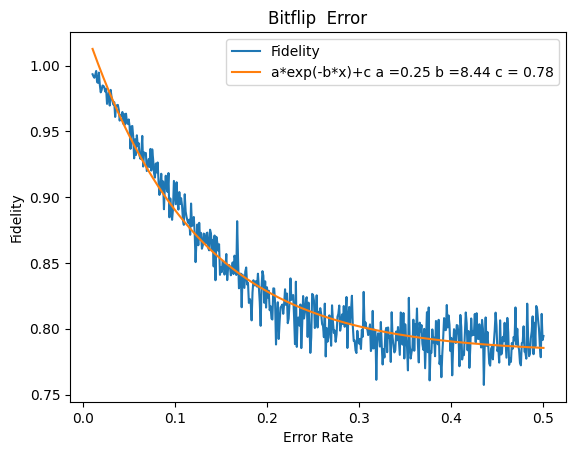
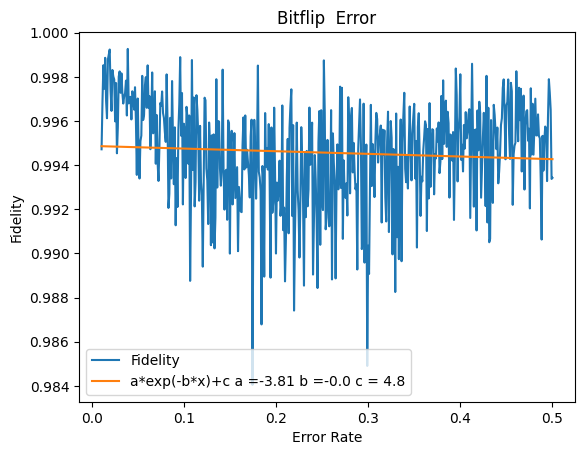

# Depolarizing Error
![Depolarizing Error_1.png](<attachment:Depolarizing Error_1.png>)
![Depolarizing Error.png](<attachment:Depolarizing Error.png>)
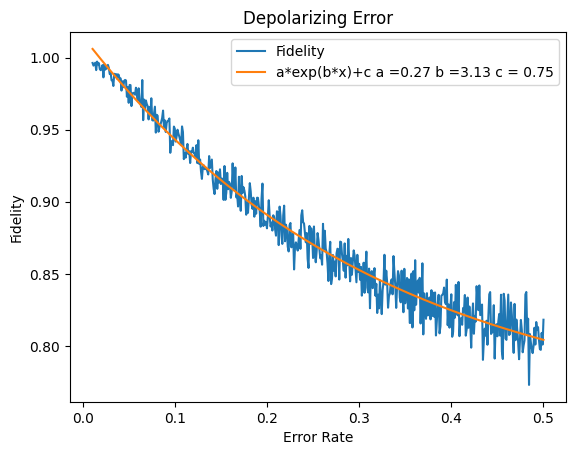
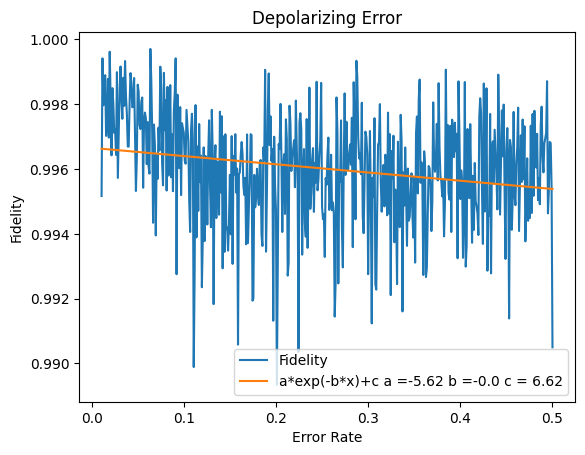

# Phase-Flip Error
![Phase Flip Error_1.png](<attachment:Phase Flip Error_1.png>)
![Phase Flip Error.png](<attachment:Phase Flip Error.png>)
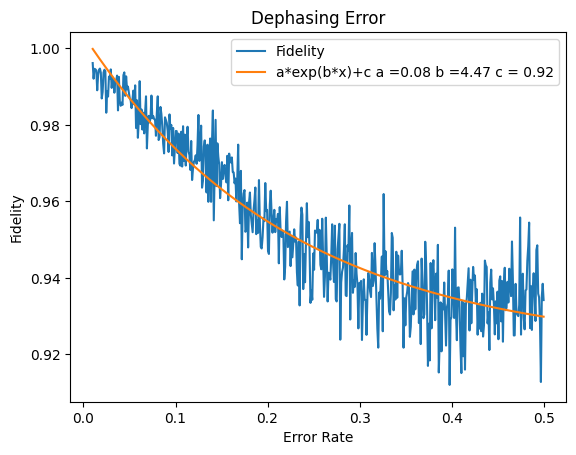
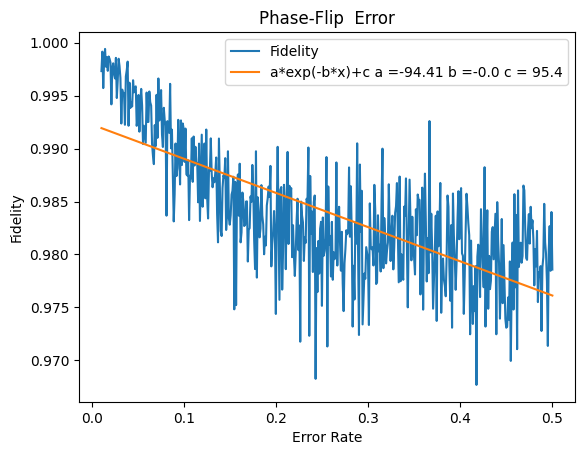

# Phase Damping Error
![Phase Damping Error_1.png](<attachment:Phase Damping Error_1.png>)
![Phase Damping Error.png](<attachment:Phase Damping Error.png>)
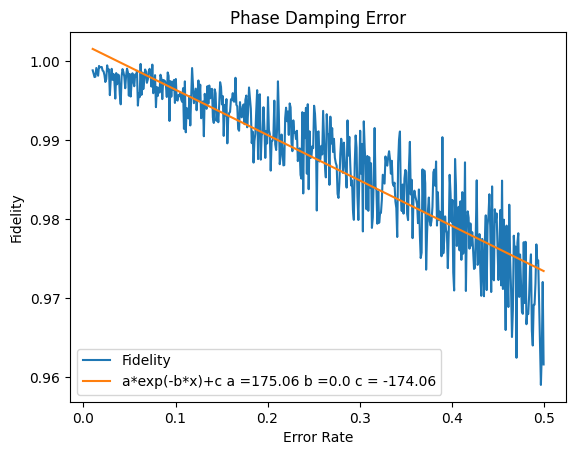
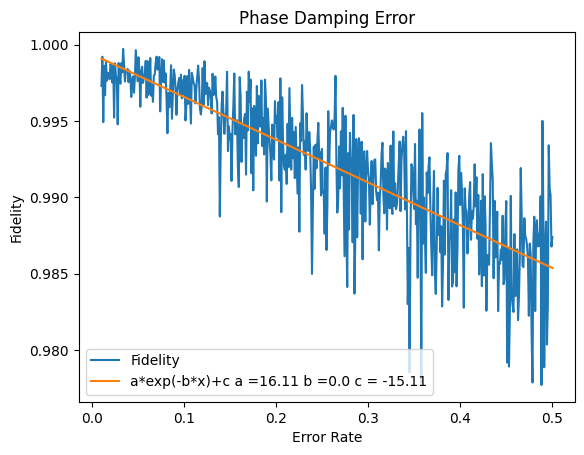

# Amplitude Damping Error
![Amplitude Damping Error_1.png](<attachment:Amplitude Damping Error_1.png>)
![Amplitude Damping Error.png](<attachment:Amplitude Damping Error.png>)
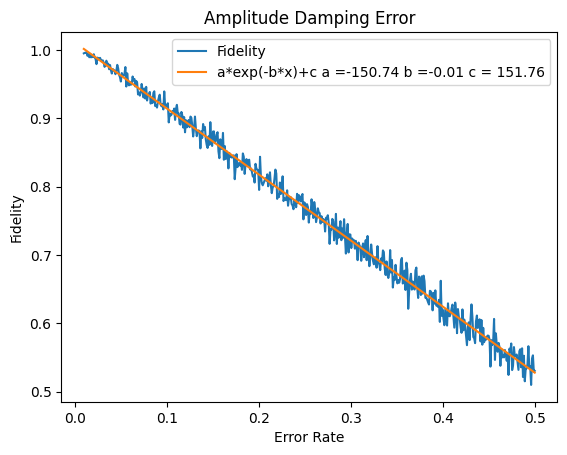
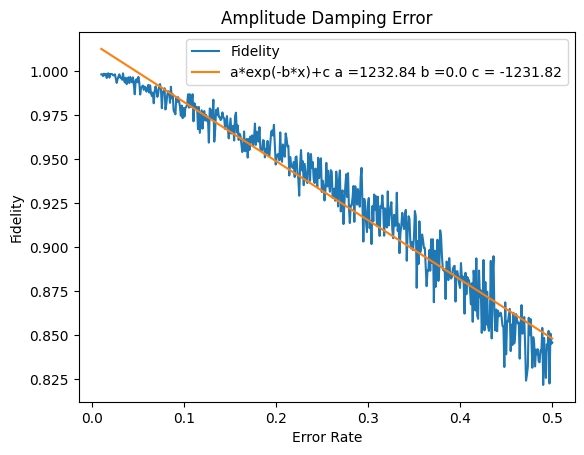

## 3) Divide and Conquer Embedding

In [80]:
def divide_and_conquer(x,dev = None,verbose=False):
  """
  Conduct Amplitude Embdding

  Args
    - x (numpy.tensor): a length-N vector

  Returns
    - state (qml.measurements.StateMP): Embedded state
  """
 

  x = x/np.linalg.norm(x)
  print(x)
  N = np.shape(x)[0]
  num_qubits = int(np.ceil(np.log2(N)))
  x_temp = np.zeros(2**(num_qubits),dtype=complex)
  x_temp[:N] = x



  N_nearest = nearest_tree_num(N-1)[0]
  tree = generate_tree((nearest_tree_num(N_nearest+1))[0])
  qubits = rearrange_qubits(generate_tree(N_nearest)) 
  
  if dev is None:
    dev = qml.device("default.qubit", wires=range(2**num_qubits))



  def gen_angles(x):
    if len(x) > 1:
      new_x = [0]*int(len(x)/2)
      for k in range(len(new_x)):
        new_x[k] = np.sqrt(abs(x[2*k])**2+abs(x[2*k+1])**2)
      inner_angles = gen_angles(new_x)
      angles = [0] * int(len(x)/2)
      for k in range(len(new_x)):
        if new_x[k] !=0:
          if x[2*k]> 0:
            angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
          else:
            angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
        else:
          angles[k] = 0

      angles = angles + inner_angles
    elif len(x) == 1:
      angles = []

    return angles
  

  def gen_angles_z(x):
    if len(x) > 1:
      new_x = [0]*int(len(x)/2)
      
      for k in range(len(new_x)):
        new_x[k] = (x[2*k]+x[2*k+1])/2
        
    
      inner_angles_z = gen_angles_z(new_x)  

      angles_z = [0] * int(len(x)/2)
      for k in range(len(new_x)):
        angles_z[k] = (x[2*k+1]-x[2*k])
        
   
      angles_z = inner_angles_z + angles_z

    elif len(x) == 1:
      angles_z = []
    return angles_z


  @qml.qnode(dev)
  def amplitude_embedding():

    angle = gen_angles(abs(x))

    phases = np.angle(x)
    
    angle_z = gen_angles_z(phases)
    

    for k in range(len(angle)):
      qml.RY(angle[k],qubits[k])

    for k in range(len(angle_z)):
      qml.RZ(angle_z[k],qubits[k])

    
    actual = obtain_parent(tree,N_nearest-1)
    while actual >=0:
      left_index = obtain_child_index(tree,actual)[0]
      right_index = obtain_child_index(tree,actual)[1]    
      while right_index < N_nearest:
        qml.CSWAP([qubits.index(actual), qubits.index(left_index), qubits.index(right_index)])
        left_index = obtain_child_index(tree,left_index)[0]
        right_index = obtain_child_index(tree,right_index)[0]
      actual = actual-1 
    measure_qubits = [N_nearest-1]
    tree_actual = generate_tree(N_nearest)
    temp_index = N_nearest-1
    for _ in range(len(tree_actual)-1):
      temp_index = qubits.index(obtain_parent(tree_actual,qubits[temp_index]))    
      measure_qubits.append(temp_index)
    measure_qubits.reverse()
    return qml.probs(measure_qubits)
  if verbose:
    print(qml.draw(amplitude_embedding)())
    print()
  state = np.sqrt(amplitude_embedding())
  return state

In [56]:
def simulate_divide(x, p_list):
    F_list = []
    N = np.shape(x)[0]
    num_qubits = (int)(np.log2(N))
    for p in p_list:
        bit_flip = pauli_error([('X', p), ('I', 1 - p)])
        phase_flip = pauli_error([('Z', p), ('I', 1 - p)])
        depolarizing = depolarizing_error(p, 1)
        phase_damping = noise.phase_damping_error(p)
        amplitude_damping = noise.amplitude_damping_error(p)

        my_noise_model = NoiseModel()
        #my_noise_model.add_all_qubit_quantum_error(bit_flip, ["ry","h",'rz'])
        #my_noise_model.add_all_qubit_quantum_error(phase_flip, ["ry","h","rz"])
        #my_noise_model.add_all_qubit_quantum_error(depolarizing, ['ry',"h","rz"])
        #my_noise_model.add_all_qubit_quantum_error(phase_damping, ['ry',"rz","h"])
        my_noise_model.add_all_qubit_quantum_error(amplitude_damping, ['ry','rz','h'])

        dev = qml.device('qiskit.aer', wires=range(2**(num_qubits)), noise_model = my_noise_model)
 
        x_noisy = divide_and_conquer(x,dev)
        x_noisy_density = np.outer(x_noisy,x_noisy)
        F = qml.math.fidelity(x_density,x_noisy_density)
        F_list.append(F)
    return F_list

In [ ]:
p_list = np.linspace(0.01,0.5,500)
p_list = p_list.tolist()
fidelities_divide = simulate_divide(x,p_list)

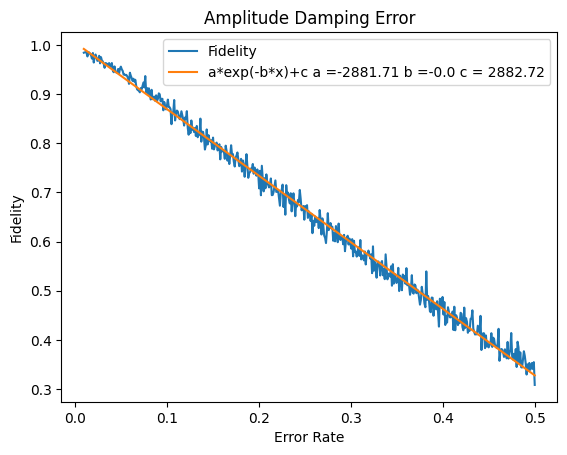

In [59]:
import matplotlib.pyplot as plt
import scipy

plt.plot(p_list,fidelities_divide,label="Fidelity")
plt.title("Amplitude Damping Error")
plt.ylabel("Fidelity")
plt.xlabel("Error Rate")

def exp(x,a,b,c):
    return a*np.exp(-b*x)+c

popt, pcov  = scipy.optimize.curve_fit(exp,p_list,fidelities_divide,maxfev=50000)

plt.plot(p_list,exp(np.array(p_list),*popt),label="a*exp(-b*x)+c" + " " + "a =" + f"{round(popt[0],2)}" + " b =" +  f"{round(popt[1],2)}" + " " +  "c = " +  f"{round(popt[2],2)}")
plt.legend()


# Bit-Flip Error

![Bit Flip Error_Divide_And_Conquer.png](<attachment:Bit Flip Error_Divide_And_Conquer.png>)
![Bit Flip Error_Divide_And_Conquer_1.png](<attachment:Bit Flip Error_Divide_And_Conquer_1.png>)

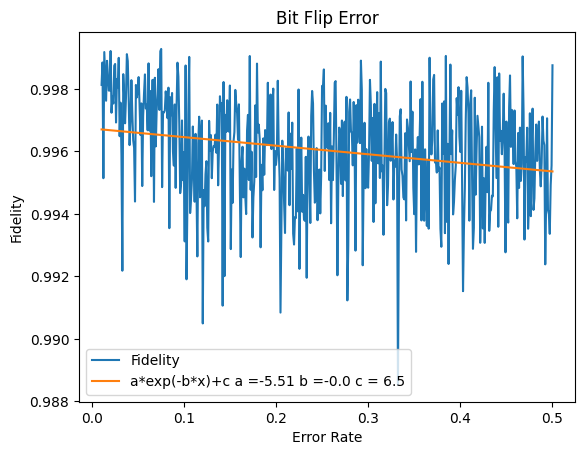
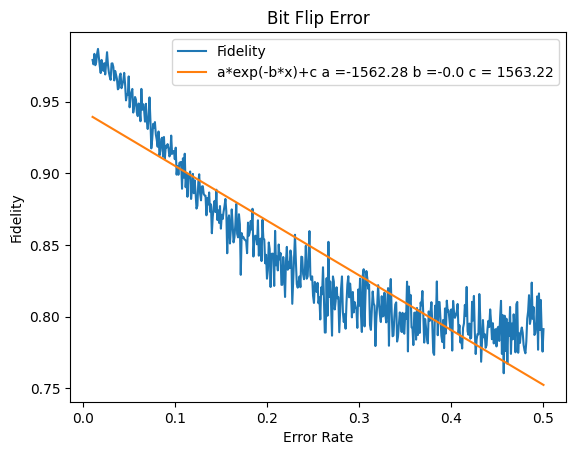

# Phase-Flip Error
![Phase Damping Error_Divide_And_Conquer.png](<attachment:Phase Damping Error_Divide_And_Conquer.png>)
![Phase Damping Error_Divide_And_Conquer_1.png](<attachment:Phase Damping Error_Divide_And_Conquer_1.png>)
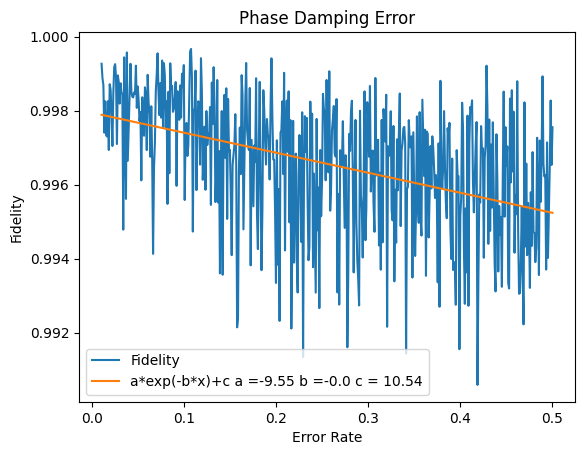
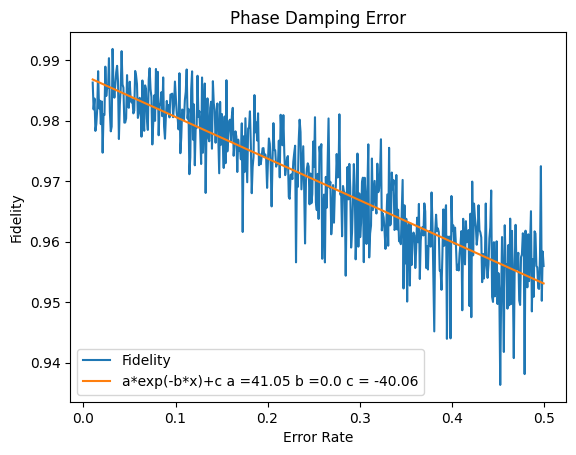

# Depolarizing Error
![Depolarizing Error_Divide_And_Conquer.png](<attachment:Depolarizing Error_Divide_And_Conquer.png>)
![Depolarizing Error_Divide_And_Conquer_1.png](<attachment:Depolarizing Error_Divide_And_Conquer_1.png>)
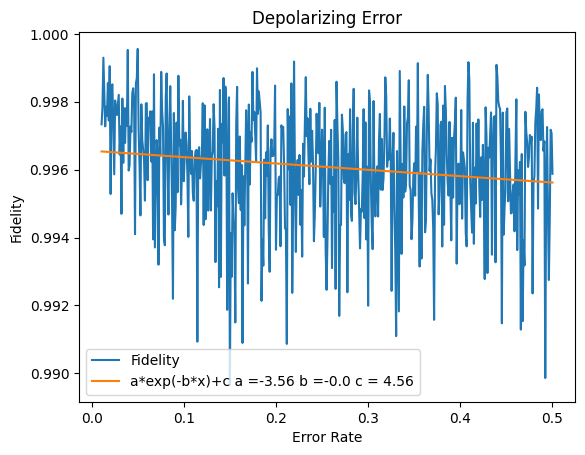
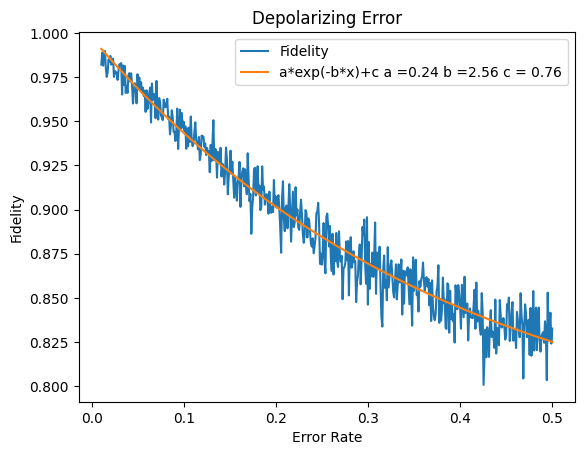

# Phase Damping Error
![Phase Damping Error_Divide_And_Conquer.png](<attachment:Phase Damping Error_Divide_And_Conquer.png>)
![Phase Damping Error_Divide_And_Conquer_1.png](<attachment:Phase Damping Error_Divide_And_Conquer_1.png>)
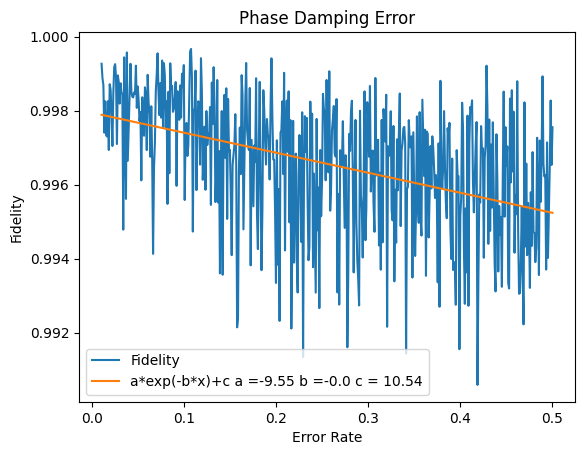
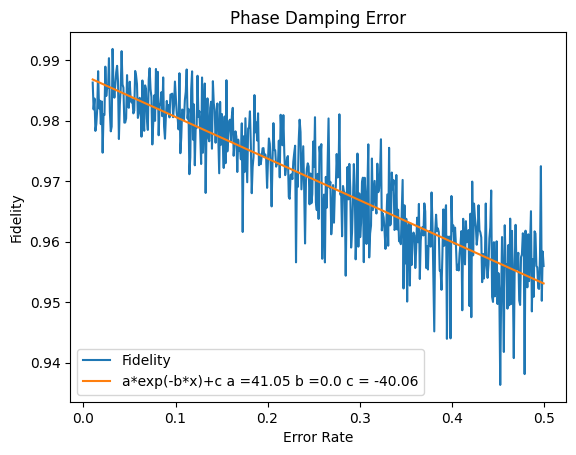

# Amplitude Damping Error
![Amplitude Damping Error_Divide_And _Conquer.png](<attachment:Amplitude Damping Error_Divide_And _Conquer.png>)
![Amplitude Damping Error_Divide_And _Conquer_1.png](<attachment:Amplitude Damping Error_Divide_And _Conquer_1.png>)
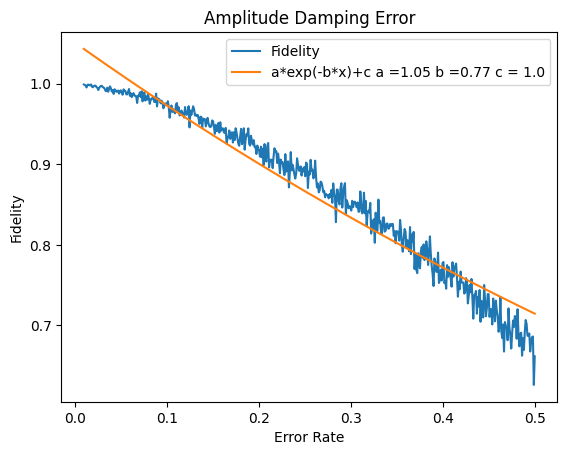
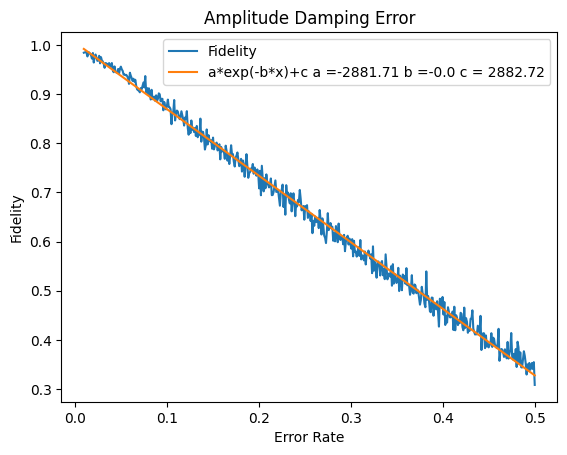

# Time Complexity
Here we compare the time complexity of the two schemes, for different qubit sizes.

2
[0.18257419 0.36514837 0.54772256 0.73029674]
3
[0.070014   0.14002801 0.21004201 0.28005602 0.35007002 0.42008403
 0.49009803 0.56011203]


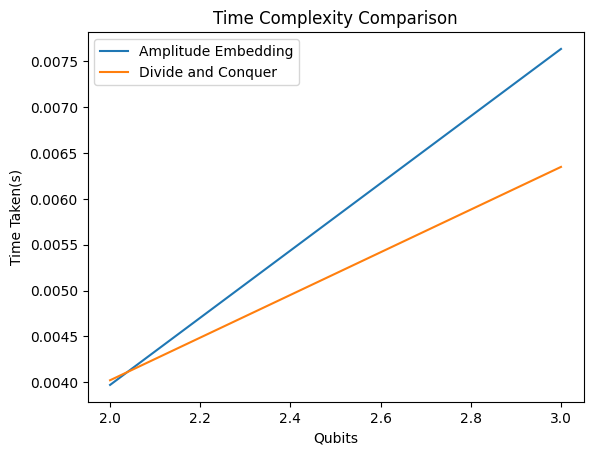

In [100]:
import time
amplitude_times = []
divide_times = []
qubits = list(range(2,6))
for qubit in qubits:
    x = np.array(list(range(1,2**qubit+1)))
    x = x/np.linalg.norm(x)
    print(qubit)
    dev_1 = qml.device('default.qubit',wires=range(qubit))
    dev_2 = qml.device("default.qubit",wires= range(2**qubit))
    start_1  = time.time()
    amplitude_embedding(x,dev_1)
    end_1 = time.time()
    amplitude_times.append(end_1-start_1)    
    start_2 = time.time()
    divide_and_conquer(x,dev_2)
    end_2 = time.time()
    divide_times.append(end_2-start_2)



plt.plot(qubits, amplitude_times,label="Amplitude Embedding")
plt.plot(qubits,divide_times, label="Divide and Conquer")
plt.title("Time Complexity Comparison")
plt.xlabel("Qubits")
plt.ylabel("Time Taken(s)")
plt.legend()
    

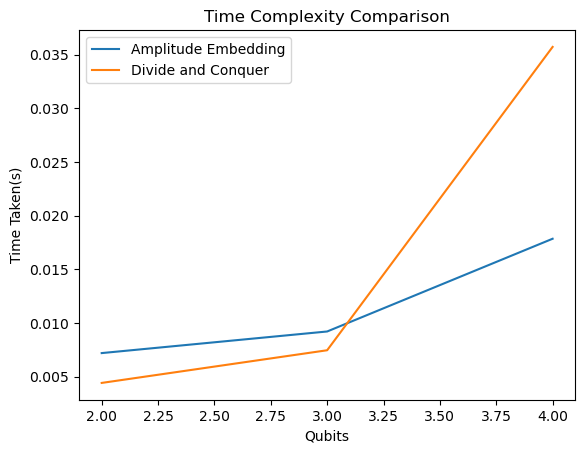

# Discussion

We have seen that the divide-and-conquer algortihm does not sacrifice error robustness despite the large increase in required qubit numbers. This is due to the tradeoff of circuit depth for circuit width, which has the effect of sacrificiing space complexity for time complexity, as we have seen from the time comparison graph, the time gap between the two schemes increases with the number of qubits. Despite these advantages, the scheme has the flaw that only states of the form $2^n$ can be stored, where $n$ is a natural number. To circumvent this issue, a possible solution is by concatenating the vector with entires of 0 until it reaches the desired length, which is implemented in the code above. Another short-coming of the algorithm, which is a disadvantage of ampltiude embedding in general, is that the scheme is limited to normalized vectors. A possible solution to this(not mentioned in the paper) is to create two additional circuits to store the normalization factor, one circuit will store the integer part using basis encoding, while the other will store the decimal part in the form of a phase. The phase can later be determined by the use of Quantum Phase Estimation. 

In addition, for both schemes, the robustness was greatly enhanced the closer the input state is to the uniform entangled state. This is due to to less actual information being stored in the state, leading to a higher chance of the state being altered the more "specific" it is.

In conclusion we have shown through simulations that the divide-and-conquer allows for a speed-up without sacrificing error robustness in exchange for space complexity in the form of additional qubits.

# Implementation of normaliazation storage circuit

In [81]:

def store_normalization_constant(constant):
    integer_part = int(constant)
    decimal_part = constant-int(constant)
    binary_integer = np.binary_repr(integer_part)
    length = len(binary_integer)
    dev= qml.device("default.qubit",wires=range(length+1))
    phase = 2*np.pi*decimal_part

    @qml.qnode(dev)
    def circuit():
        for i in range(length):
            if binary_integer[i] == "1":
                qml.PauliX(i)
        qml.Hadamard(wires=length)
        qml.PhaseShift(phase, wires=length)
    
        return qml.state()
    
    return circuit()


def decode_normalization(state):
    index = np.where(state != 0)[0][1]

    binary = np.binary_repr(index)
    binary = binary[:-1]
    integer_part = int(binary,2)
    decimal_part = np.angle(state[index])/(2*np.pi)
    decimal_part = float(decimal_part)

    return integer_part + decimal_part
    


    

In [97]:

x = np.array([1,2,3,4,5,6,7,8])
x_norm = x/np.linalg.norm(x)
state_1 = divide_and_conquer(x)
state_2 = store_normalization_constant(np.linalg.norm(x))
norm_obtained = decode_normalization(state_2)

[0.070014   0.14002801 0.21004201 0.28005602 0.35007002 0.42008403
 0.49009803 0.56011203]


In [99]:
x_norm*norm_obtained

tensor([1., 2., 3., 4., 5., 6., 7., 8.], requires_grad=True)

# Bibliography

[1] Araujo, I.F., Park, D.K., Petruccione, F. et al. A divide-and-conquer algorithm for quantum state preparation. Sci Rep 11, 6329 (2021). https://doi.org/10.1038/s41598-021-85474-1